In [604]:
!pip install keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [605]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [606]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import LSTM,Dense,Conv1D
from kerastuner import RandomSearch
from keras.metrics import MeanAbsolutePercentageError,RootMeanSquaredError
from keras_tuner import HyperModel
from keras_tuner import HyperParameters as hp

In [607]:
import matplotlib.pyplot as plt

In [608]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import Dropout


In [609]:
from google.colab import drive

In [610]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [611]:
import os
os.environ['Kaggle_config_dir']='/content/gdrive/MyDrive/Colab Notebooks/Kaggle'#

In [612]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Kaggle

/content/gdrive/MyDrive/Colab Notebooks/Kaggle


In [613]:
#!ls

In [614]:
class MyHypermodel(HyperModel):
  def __init__(self,entrada):
    self.entrada=entrada
  def build(self,hp):
    modelo=Sequential()
    modelo.add(LSTM(units=hp.Int('units_1',80,160,step=40),input_shape=self.entrada,return_sequences=True))#(x_train.shape[1],1) Int('units1',80,150,step=40)
    modelo.add(LSTM(units=hp.Int('units_2',160,320,step=40),return_sequences=True))# neurona del MV1 Int('units_2',140,500,step=40) 
    modelo.add(LSTM(units=hp.Int('units_3',640,720,step=40))) #neurona del MV1 Int('units_3',500,800,step=40)
    modelo.add(Dropout(rate=hp.Float('r',0.09,0.2,step=0.025)))
    modelo.add(Dense(units=1))
    modelo.compile(optimizer='adam',loss='mse',metrics=[MeanAbsolutePercentageError(name='mse')])
    return modelo
    
  def fit(self,hp,modelo,*args,**kwargs):
    #epocas=hp.Int("epochs",min_value=40,max_value=60,step=20)
    return modelo.fit(*args,validation_split=0.27, epochs=hp.Choice('epocas',[200,500,1000,1500]),batch_size=35,**kwargs)


#Serie con red neuronal

In [615]:
dolar_y=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/trm3.csv',sep=';')

In [616]:
dolar_y['Fecha']=pd.to_datetime(dolar_y['Fecha'])

In [617]:
#dolar_y=dolar_y.set_index(dolar_y['Fecha'])
#del dolar_y['Fecha']

In [618]:
#dolar_y=dolar_y.asfreq('D')

In [619]:
dolar_y['COP/USD']=dolar_y['COP/USD'].replace(',','.',regex=True)

In [620]:
dolar_y['COP/USD']=dolar_y['COP/USD'].astype(float)

In [621]:
dolar_y.head()

,Fecha,COP/USD
0,1991-11-27,693.32
1,1991-11-28,693.99
2,1991-11-29,694.70
3,1991-11-30,694.70
4,1991-12-01,643.42


In [622]:
dolar_y=dolar_y.drop_duplicates()

In [623]:
list_anios=dolar_y['Fecha'].dt.year.unique().tolist()

In [624]:
list_anios.remove(2023)

In [625]:
list_anios.remove(1991)

In [626]:
dolar2023=dolar_y[(dolar_y['Fecha']>=f'{2023}-01-04')]

In [627]:
dolar2023=dolar2023.fillna(np.mean)

In [628]:
dolar2023.head()

,Fecha,COP/USD
11356,2023-01-04,4842.26
11357,2023-01-05,4924.00
11358,2023-01-06,4989.58
11359,2023-01-07,4885.66
11360,2023-01-08,4885.66


In [629]:
dolar2023aux=dolar2023[dolar2023['Fecha']<='2023-02-21']

In [630]:
dolar2023aux=dolar2023[dolar2023['Fecha']<='2023-02-21']


In [631]:
error=[]
for j in list_anios:
  comparate=dolar_y[(dolar_y['Fecha']>=f'{j}-01-04')&(dolar_y['Fecha']<=f'{j}-02-21')]
 # comparate=comparate.fillna(np.mean)
  means=mean_squared_error(dolar2023aux.iloc[:,1],comparate.iloc[:,1],squared=False)
  if means<2000:#el valor del mejor modelo es decir el 1, fue creado con 2000
    error.append(j)
  

In [632]:
error

[2003, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [633]:
d=pd.DataFrame()
data_min=[]
for z in error:
  a=dolar_y[(dolar_y['Fecha']>=f"{z}-01-04")&(dolar_y['Fecha']<=f'{z+1}')]
  for i in range(0,360):
    data_min.append(a.iloc[i,1])
  d[z]=data_min
  data_min.clear()

In [634]:
d.head()

,2003,2016,2017,2018,2019,2020,2021,2022
0,2841.56,3149.47,2981.06,2908.68,3241.20,3262.05,3432.50,4082.75
1,2841.56,3213.24,2965.36,2885.76,3208.56,3262.05,3420.78,4084.11
2,2841.56,3203.86,2941.08,2898.32,3208.56,3262.05,3450.74,4042.36
3,2841.56,3250.69,2919.01,2898.32,3208.56,3262.05,3428.04,4039.31
4,2881.83,3287.28,2919.01,2898.32,3208.56,3264.26,3459.39,4043.46


In [635]:
data_min=d.copy()

In [636]:
data_min.head()

,2003,2016,2017,2018,2019,2020,2021,2022
0,2841.56,3149.47,2981.06,2908.68,3241.20,3262.05,3432.50,4082.75
1,2841.56,3213.24,2965.36,2885.76,3208.56,3262.05,3420.78,4084.11
2,2841.56,3203.86,2941.08,2898.32,3208.56,3262.05,3450.74,4042.36
3,2841.56,3250.69,2919.01,2898.32,3208.56,3262.05,3428.04,4039.31
4,2881.83,3287.28,2919.01,2898.32,3208.56,3264.26,3459.39,4043.46


In [637]:
fechas=pd.date_range(start='2023-01-04',end='2023-12-29',freq='D')

In [638]:
data_min=data_min.set_index(fechas)

In [639]:
data_min.head()

,2003,2016,2017,2018,2019,2020,2021,2022
2023-01-04,2841.56,3149.47,2981.06,2908.68,3241.20,3262.05,3432.50,4082.75
2023-01-05,2841.56,3213.24,2965.36,2885.76,3208.56,3262.05,3420.78,4084.11
2023-01-06,2841.56,3203.86,2941.08,2898.32,3208.56,3262.05,3450.74,4042.36
2023-01-07,2841.56,3250.69,2919.01,2898.32,3208.56,3262.05,3428.04,4039.31
2023-01-08,2881.83,3287.28,2919.01,2898.32,3208.56,3264.26,3459.39,4043.46


In [640]:
normalizador_X=MinMaxScaler()

In [641]:
data_min=normalizador_X.fit_transform(data_min.values)

In [642]:
data_min=pd.DataFrame(data_min,columns=d.columns,index=fechas)

In [643]:
data_min.head()

,2003,2016,2017,2018,2019,2020,2021,2022
2023-01-04,0.275850,0.525178,0.561963,0.347976,0.375585,0.009066,0.019858,0.277495
2023-01-05,0.275850,0.631265,0.500334,0.308753,0.303128,0.009066,0.000000,0.278499
2023-01-06,0.275850,0.615661,0.405025,0.330247,0.303128,0.009066,0.050762,0.247670
2023-01-07,0.275850,0.693567,0.318391,0.330247,0.303128,0.009066,0.012301,0.245418
2023-01-08,0.504891,0.754438,0.318391,0.330247,0.303128,0.011522,0.065419,0.248483


In [644]:
np.random.seed(123)

In [645]:
entrenamiento=data_min[data_min.index<='2023-02-21']#2023-02-21

In [646]:
testeo=data_min[data_min.index>'2023-02-21']#2023-02-21

In [647]:
f_ts=testeo.index#fechas de los test para el pronostico

In [648]:
data_min.isna().sum()

2003    0
2016    0
2017    0
2018    0
2019    0
2020    0
2021    0
2022    0
dtype: int64

In [649]:
dolar2023=dolar2023.set_index(dolar2023['Fecha'])
del dolar2023['Fecha']

In [650]:
f_completas_train=dolar2023.index
f_train_y=dolar2023.index

In [651]:
f_train_y=f_train_y[f_train_y<='2023-02-21']

In [652]:
normalizador_y=MinMaxScaler()

In [653]:
norm=dolar_y[(dolar_y['Fecha']>='2022')]#modelVA 2019 modelV1 2022
normalizador_y.fit(norm[['COP/USD']])

MinMaxScaler()

In [654]:
dolar2023=normalizador_y.transform(dolar2023)

In [655]:
dolar2023=pd.DataFrame(dolar2023,columns=['TRM'],index=f_completas_train)

In [656]:
entren_Y=dolar2023[dolar2023.index<='2023-02-21']

In [657]:
test_Y=dolar2023[(dolar2023.index>'2023-02-21')&(dolar2023.index<'2023-04-22')]

In [658]:
test_Y.head()

,TRM
Fecha,
2023-02-22,0.918125
2023-02-23,0.899355
2023-02-24,0.846920
2023-02-25,0.843782
2023-02-26,0.843782


In [659]:
x_t=np.array(entrenamiento)
y_t=np.array(entren_Y)

In [660]:
hipmod=MyHypermodel((x_t.shape[1],1))

In [661]:
tuner=RandomSearch(hipmod,objective=('val_mse'),max_trials=2, directory='busqueda_red_neuronal',project_name='modelV1')#el mejor modelo ha sido modelV1

Mejores modelos han sido modelV1 modelVA

In [662]:
tuner.search(x_t,y_t)

In [663]:
tuner.results_summary()

Results summary
Results in busqueda_red_neuronal/modelV1
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 0 summary
Hyperparameters:
units1: 80
units_2: 220
units_3: 620
r: 0.2
optimizer: adam
epocas: 200
Score: 10.865867614746094

Trial 5 summary
Hyperparameters:
units1: 120
units_2: 500
units_3: 580
r: 0.35
optimizer: rmsprop
epocas: 200
Score: 32.48239517211914

Trial 2 summary
Hyperparameters:
units1: 80
units_2: 140
units_3: 620
r: 0.4
optimizer: rmsprop
epocas: 1000
Score: 33.122352600097656

Trial 3 summary
Hyperparameters:
units1: 120
units_2: 420
units_3: 740
r: 0.1
optimizer: adam
epocas: 1000
Score: 36.77070999145508

Trial 4 summary
Hyperparameters:
units1: 120
units_2: 260
units_3: 740
r: 0.15000000000000002
optimizer: adam
epocas: 2000
Score: 37.81142807006836

Trial 1 summary
Hyperparameters:
units1: 120
units_2: 500
units_3: 500
r: 0.30000000000000004
optimizer: adam
epocas: 500
Score: 41.00355911254883


In [664]:
mod=tuner.get_best_models(num_models=1)[0]

In [665]:
dolar_prediccion=mod.predict(x_t)

2/2 [==============================] - 1s 9ms/step


In [666]:
dolar_prediccion=pd.DataFrame(normalizador_y.inverse_transform(dolar_prediccion),columns=['dolar'])

In [667]:
entren_Y=pd.DataFrame(normalizador_y.inverse_transform(y_t),columns=['dolar'])

In [668]:
import plotly.express as pg

In [669]:
testeo1=np.array(testeo)

In [670]:
predicts=mod.predict(testeo1)

10/10 [==============================] - 0s 4ms/step


In [671]:
pronosticoanio=pd.DataFrame(normalizador_y.inverse_transform(predicts),index=f_ts)

In [672]:
pronosticoanio.column='TRM'

In [673]:
pronosticoanio=pronosticoanio.rename(columns={0:'TRM'})

In [674]:
f_t_index=test_Y.index

In [675]:
prueba=pd.DataFrame(normalizador_y.inverse_transform(test_Y),index=f_t_index)

In [676]:
filtropronostico=pronosticoanio[pronosticoanio.index<='2023-04-21']

In [677]:
RvsM=prueba.merge(filtropronostico,how='inner',left_index=True,right_index=True)

In [678]:
RvsM=RvsM.rename(columns={0:'TRM_Real', 'TRM':'TRM_Modelo'})

In [679]:
RvsM.head()

,TRM_Real,TRM_Modelo
2023-02-22,4950.33,4627.170898
2023-02-23,4924.91,4604.659668
2023-02-24,4853.90,4581.905273
2023-02-25,4849.65,4616.807617
2023-02-26,4849.65,4606.147949


In [680]:
from sklearn.metrics import mean_absolute_percentage_error

In [681]:
mean_squared_error(RvsM['TRM_Real'],RvsM['TRM_Modelo'],squared=False)

142.64609245558512

In [682]:
mean_absolute_percentage_error(RvsM['TRM_Real'],RvsM['TRM_Modelo'])

0.02450276621901688

In [683]:
pg.line(x=RvsM.index,y=[RvsM['TRM_Real'],RvsM['TRM_Modelo']])

In [684]:
pg.line(x=pronosticoanio.index,y=pronosticoanio['TRM'])

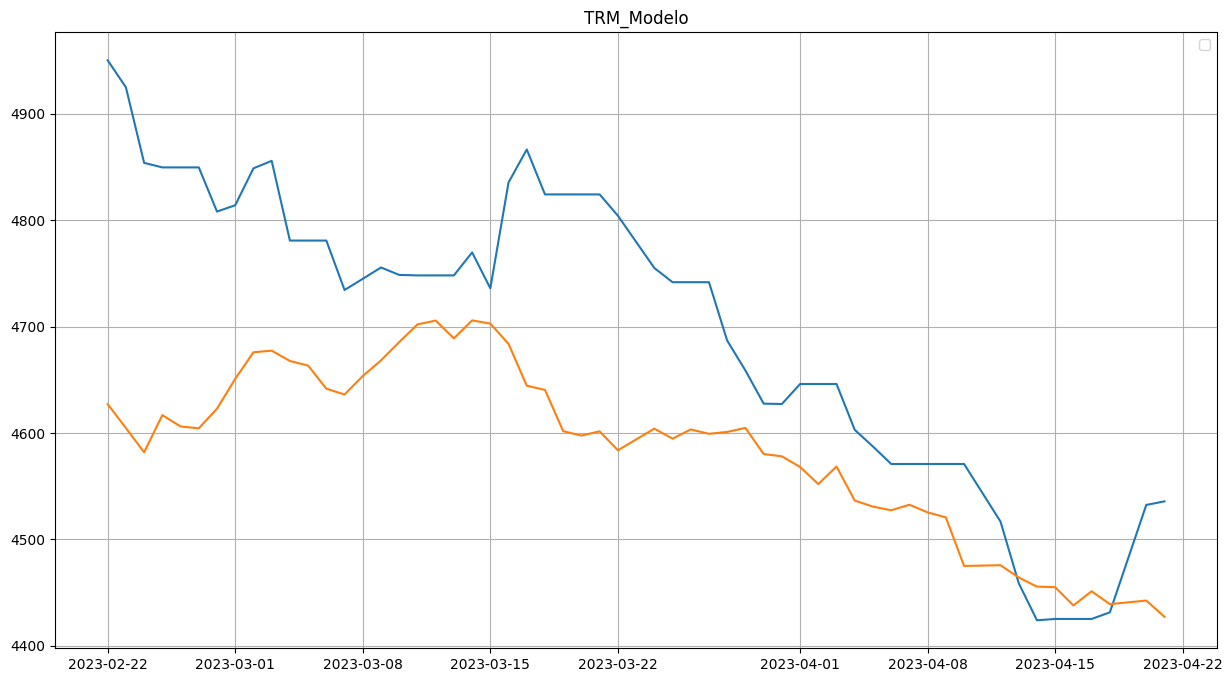

In [697]:
plt.figure(figsize=(15,8))
plt.plot(RvsM.loc[:,['TRM_Real','TRM_Modelo']])
plt.title('TRM_Modelo')
plt.legend()
plt.grid()
plt.show()


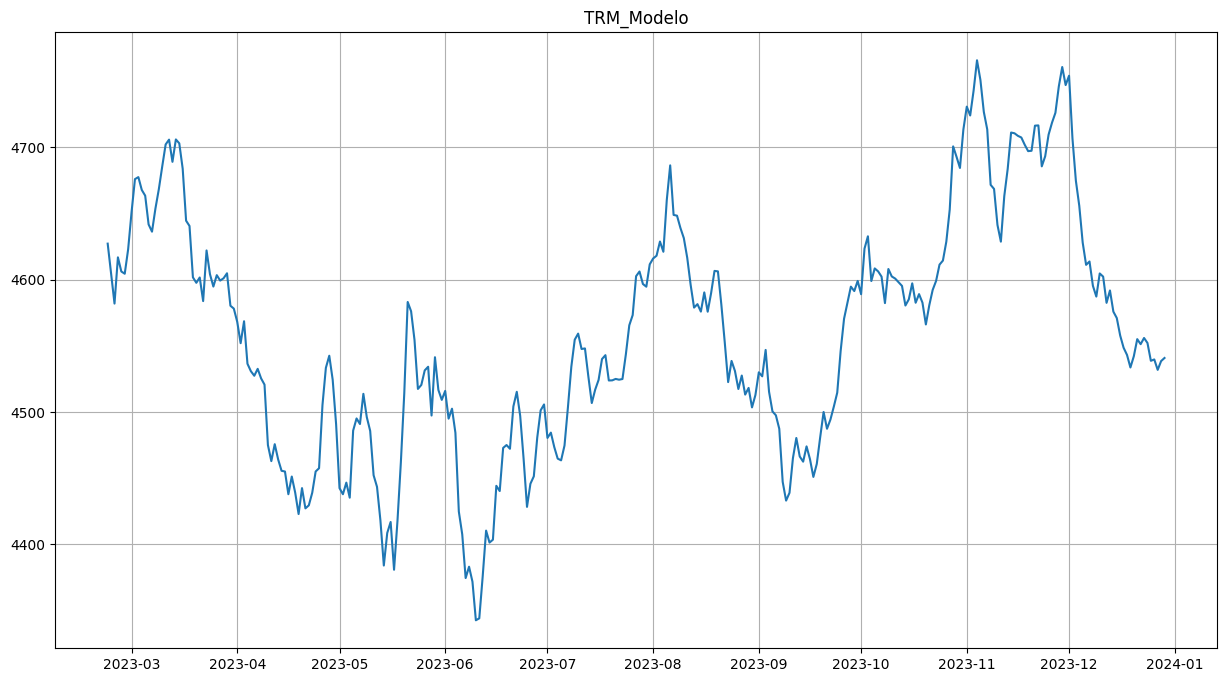

In [686]:
plt.figure(figsize=(15,8))
plt.plot(pronosticoanio.index,pronosticoanio['TRM'])
plt.title('TRM_Modelo')
plt.grid()
plt.show()

In [687]:
pronosticoanio.to_excel('dolar.xlsx')

In [688]:
RvsM.to_excel('Real_modelo.xlsx')